In [1]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

from visualize import plot_ratemaps
from IPython.display import clear_output

/home/bsorsch/.tf2/lib/python3.5/site-packages/tqdm/autonotebook.py:17: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  " (e.g. in jupyter console)", TqdmExperimentalWarning)


# Single-cell dynamics
Here we perform numerical simulations to optimize the position-encoding Lagrangian (eq. 4). The place cell covariance matrix $\Sigma$ is estimated empirically from the same place cell outputs used to train the RNN. For comparison, we first optimize using a nonlinearity (tanh) which preserves the $g\to-g$ symmetry, and find predominantly heterogenous patterns. We then optimize with a nonlinearity (relu) which breaks the $g\to-g$ symmetry, and find predominantly hexagonal patterns. Notice that boundary effects can deform the regular hexagonal patterns in interesting ways.

In [2]:
from utils import generate_run_ID, load_trained_weights
from place_cells import PlaceCells
from trajectory_generator import TrajectoryGenerator
from model import RNN, LSTM
from trainer import Trainer

In [3]:
# Training options and hyperparameters
class Options:
    pass
options = Options()

options.save_dir = 'models'
options.n_epochs = 5          # number of training epochs
options.n_steps = 1000        # batches per epoch
options.batch_size = 200      # number of trajectories per batch
options.sequence_length = 20  # number of steps in trajectory
options.learning_rate = 1e-4  # gradient descent learning rate
options.Np = 512              # number of place cells
options.Ng = 4096             # number of grid cells
options.place_cell_rf = 0.12  # width of place cell center tuning curve (m)
options.surround_scale = 2    # if DoG, ratio of sigma2^2 to sigma1^2
options.RNN_type = 'RNN'      # RNN or LSTM
options.activation = 'relu'   # recurrent nonlinearity
options.weight_decay = 1e-4   # strength of weight decay on recurrent weights
options.DoG = True            # use difference of gaussians tuning curves
options.periodic = False      # trajectories with periodic boundary conditions
options.box_width = 2.2       # width of training environment
options.box_height = 2.2      # height of training environment

options.run_ID = generate_run_ID(options)

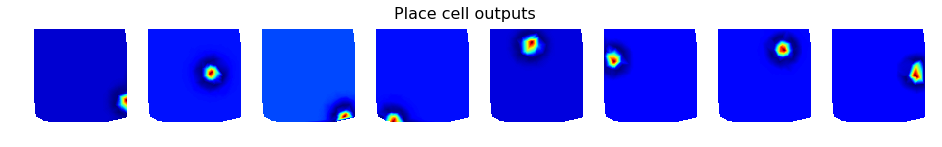

In [4]:
# Plot a few place cell outputs
place_cells = PlaceCells(options)
trajectory_generator = TrajectoryGenerator(options, place_cells)
inputs, pos, pc_outputs = trajectory_generator.get_test_batch()
pc_outputs = tf.reshape(pc_outputs, (-1, options.Np))
pc = place_cells.grid_pc(pc_outputs[::100], res=100)

plt.figure(figsize=(16,2))
for i in range(8):
    plt.subplot(1,8,i+1)
    plt.imshow(pc[i], cmap='jet')
    plt.axis('off')
        
plt.suptitle('Place cell outputs', fontsize=16)
plt.show()

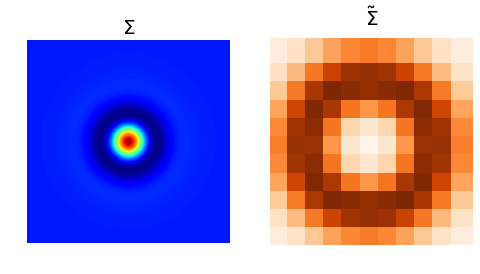

In [5]:
# Place cell ovariance matrix
res = 55
C = place_cells.compute_covariance(res=res)

# Fourier transform
Ctilde = np.fft.fft2(C)
Ctilde[0,0] = 0

plt.figure(figsize=(8,4))
plt.subplot(121)
plt.imshow(C, cmap='jet', interpolation='gaussian')
plt.axis('off')
plt.title(r'$\Sigma$', fontsize=20)

plt.subplot(122)
width = 6
idxs = np.arange(-width+1, width)
x2, y2 = np.meshgrid(np.arange(2*width-1), np.arange(2*width-1))
plt.scatter(x2,y2,c=np.abs(Ctilde)[idxs][:,idxs], s=600, cmap='Oranges', marker='s')

plt.axis('equal')
plt.axis('off')
plt.title(r'$\tilde \Sigma$', fontsize=20)
plt.axis('off');

In [6]:
def convolve_with_C(g, Ctilde):
    '''
    Convolves the input g with the kernel C
    '''
    gtilde = np.fft.fft2(g, [res, res])
    gconv = np.real(np.fft.ifft2(gtilde*Ctilde))
    gconv = np.roll(np.roll(gconv, res//2+1, axis=1), res//2+1, axis=2)
    
    return gconv

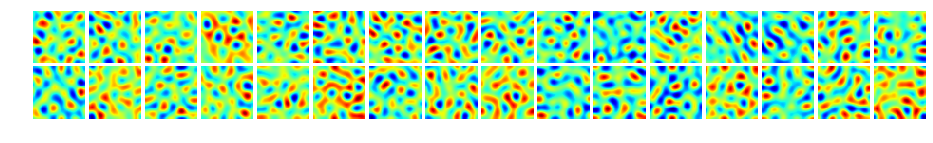

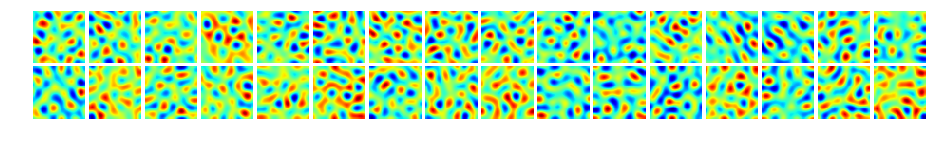

In [7]:
# Symmetry preserving nonlinearity (tanh)
Ng = 32
T = 1000
lr = 1e-4
G = np.random.randn(Ng,res,res) * 1e-8

for i in range(T):
    G +=lr*(-G + convolve_with_C(G, Ctilde))
    G = np.tanh(G)
    
    if i%100==99:
        clear_output()
        plt.pause(0.01)
        im = plot_ratemaps(G, Ng)
        plt.figure(figsize=(16,12))
        plt.imshow(im)
        plt.axis('off')

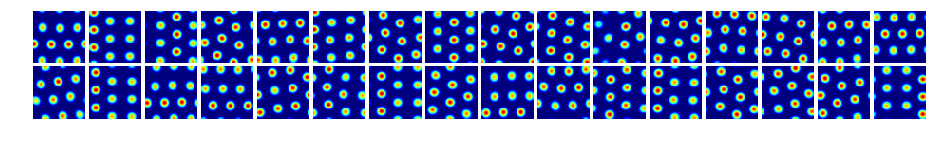

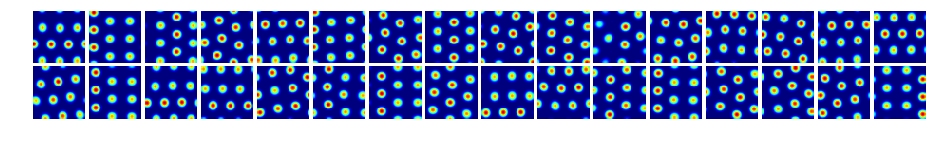

In [8]:
# Symmetry-breaking nonlinearity (relu)
def relu(x):
    return np.maximum(x,0)

Ng = 32
T = 1000
lr = 5e-3
G = np.random.randn(Ng,res,res) * 1e-8

for i in range(T):
    G +=lr*(-G + convolve_with_C(G, Ctilde))
    G = relu(G)
    
    if i%100==99:
        clear_output()
        plt.pause(0.01)
        im = plot_ratemaps(G, Ng)
        plt.figure(figsize=(16,12))
        plt.imshow(im)
        plt.axis('off')

# Multi-grid dynamics

To simulate the multiple grid cell Lagrangian (eq. 11) we include a term which orthogonalizes $G$ using a Gram-Schmidt-like procedure similar to Sanger's multiple PCA algorithm, yielding a hierarchy of grids. Here we use Gaussian place cell tuning curves to demonstrate that the nonlinearity favors hexagonal patterns even when the covariance matrix is not center-surround. However, in this case the first few patterns have square rather than hexagonal symmetry due to discretization of the Fourier lattice as a consequence of finite box size.

In [9]:
res = 55

pos_range_min=-1.1
pos_range_max=1.1
grid_x, grid_y = np.meshgrid(
                    np.linspace(pos_range_min, pos_range_max, res), 
                    np.linspace(pos_range_min, pos_range_max, res)
                )
us = np.stack([grid_x.ravel(), grid_y.ravel()]).T

sigma = 0.12
norm2 = np.linalg.norm(us, ord=2, axis=1) 
C = np.exp(-(norm2)**2 / (2.0 * sigma**2))
C = C.reshape([res,res])

In [10]:
# Construct fourier transform for later
Ctilde = np.fft.fft2(C, [res, res])

def convolve_with_C(g, Ctilde):
    '''
    Convolves the input h with the kernel J
    '''
    gtilde = np.fft.fft2(g, [res, res])
    gconv = np.real(np.fft.ifft2(gtilde*Ctilde))
    gconv = np.roll(np.roll(gconv, res//2+1, axis=1), res//2+1, axis=2)
    
    return gconv

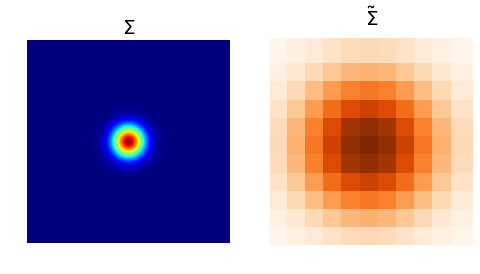

In [11]:
plt.figure(figsize=(8,4))
plt.subplot(121)
plt.imshow(C, cmap='jet', interpolation='gaussian')
plt.axis('off')
plt.title(r'$\Sigma$', fontsize=20)

plt.subplot(122)
width = 6
idxs = np.arange(-width+1, width)
x2, y2 = np.meshgrid(np.arange(2*width-1), np.arange(2*width-1))
plt.scatter(x2,y2,c=np.abs(Ctilde)[idxs][:,idxs], s=600, cmap='Oranges', marker='s')

plt.axis('equal')
plt.axis('off')
plt.title(r'$\tilde \Sigma$', fontsize=20)
plt.axis('off');

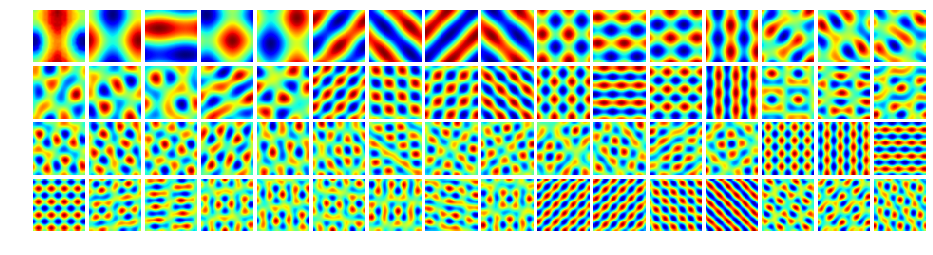

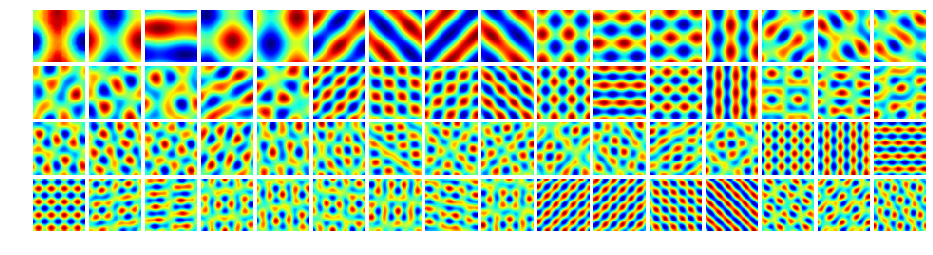

In [12]:
Ng = 64
r = 30
T = 5000
lr = 8e-3
G = np.random.randn(Ng,res,res) * 1e-8

for i in range(T):
    H = convolve_with_C(G, Ctilde)
    Hr = H.reshape([Ng, -1])
    Gr = G.reshape([Ng, -1])
    oja = Gr.T.dot(np.tril(Gr.dot(Hr.T))).T.reshape([Ng,res,res])

    G += lr * (H - oja + np.tanh(G))
    
    if i%100==99:
        clear_output()
        plt.pause(0.01)
        im = plot_ratemaps(np.flip(G), Ng)
        plt.figure(figsize=(16,12))
        plt.imshow(im)
        plt.axis('off')

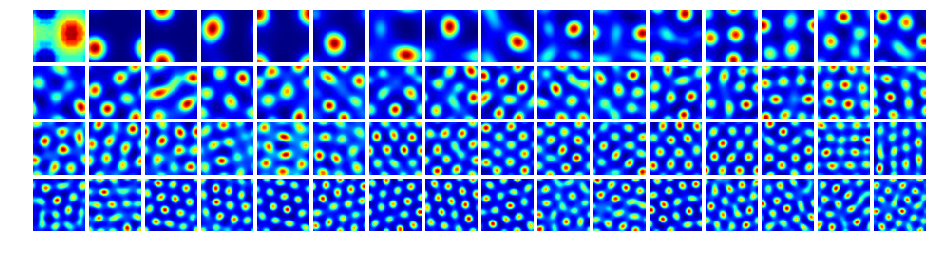

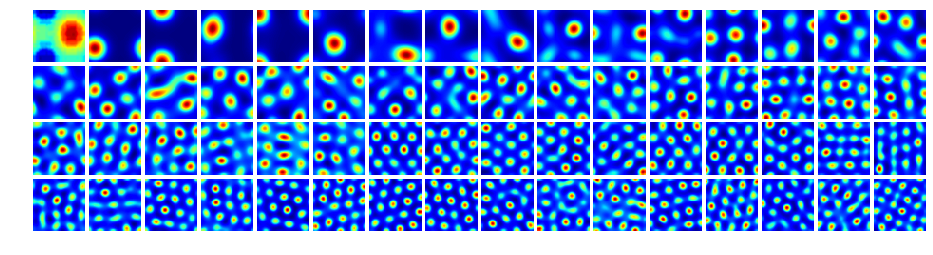

In [13]:
def phi(x,r):
    return np.maximum(r*x,0)

Ng = 64
r = 30
T = 5000
lr = 8e-3
G = np.random.randn(Ng,res,res) * 1e-8

for i in range(T):
    H = convolve_with_C(G, Ctilde)
    Hr = H.reshape([Ng, -1])
    Gr = G.reshape([Ng, -1])
    oja = Gr.T.dot(np.tril(Gr.dot(Hr.T))).T.reshape([Ng,res,res])

    G += lr * (H - oja + phi(G,r))
    
    if i%100==99:
        clear_output()
        plt.pause(0.01)
        im = plot_ratemaps(np.flip(G), Ng)
        plt.figure(figsize=(16,12))
        plt.imshow(im)
        plt.axis('off')